In [9]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [10]:
import os

train_dir = '/kaggle/input/20k-multi-class-crop-disease-images/Train'
val_dir = '/kaggle/input/20k-multi-class-crop-disease-images/Validation'

def count_images(folder):
    return sum([len(files) for r, d, files in os.walk(folder)])

print("Train images:", count_images(train_dir))
print("Validation images:", count_images(val_dir))


Train images: 15452
Validation images: 3173


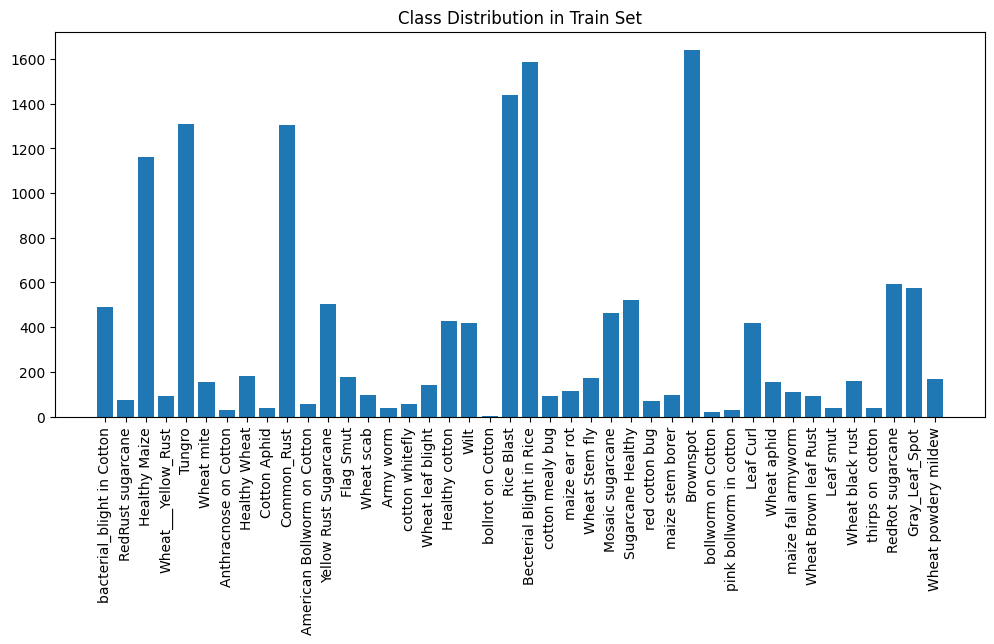

In [11]:
def get_class_distribution(folder):
    class_counts = {}
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_dist = get_class_distribution(train_dir)
val_dist = get_class_distribution(val_dir)

# Plot
plt.figure(figsize=(12, 5))
plt.bar(train_dist.keys(), train_dist.values())
plt.xticks(rotation=90)
plt.title("Class Distribution in Train Set")
plt.show()


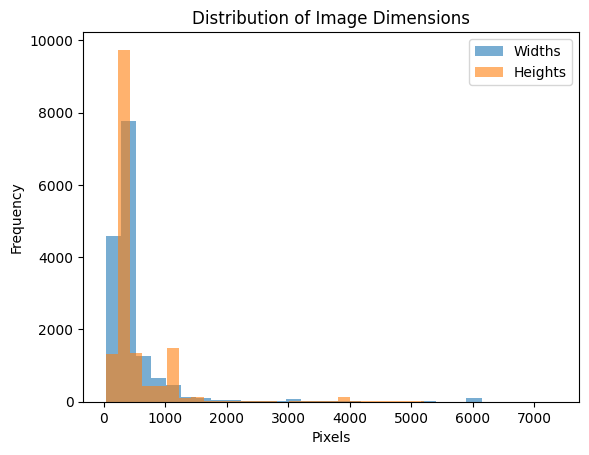

In [12]:
shapes = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        if os.path.isfile(img_path): 
            try:
                img = Image.open(img_path)
                shapes.append(img.size)  # (width, height)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

# Plotting
widths, heights = zip(*shapes)
plt.hist(widths, bins=30, alpha=0.6, label='Widths')
plt.hist(heights, bins=30, alpha=0.6, label='Heights')
plt.legend()
plt.title("Distribution of Image Dimensions")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.show()


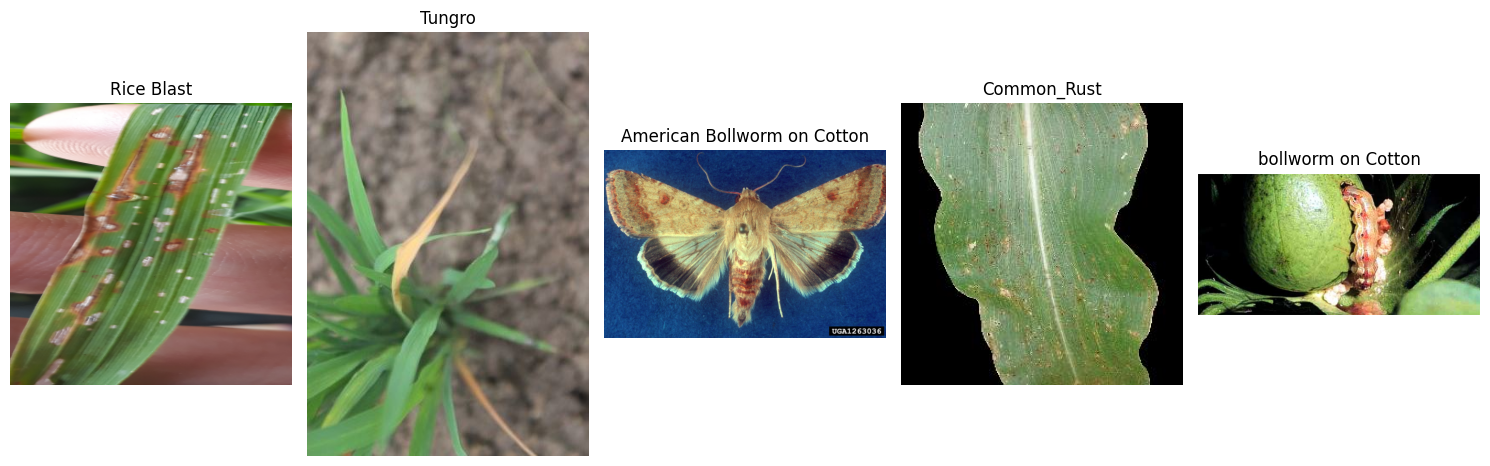

In [13]:
import random

def show_sample_images(folder, n_classes=5):
    class_names = random.sample(os.listdir(folder), n_classes)
    plt.figure(figsize=(15, 5))
    for i, cls in enumerate(class_names):
        img_path = os.path.join(folder, cls, random.choice(os.listdir(os.path.join(folder, cls))))
        img = Image.open(img_path)
        plt.subplot(1, n_classes, i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(train_dir)


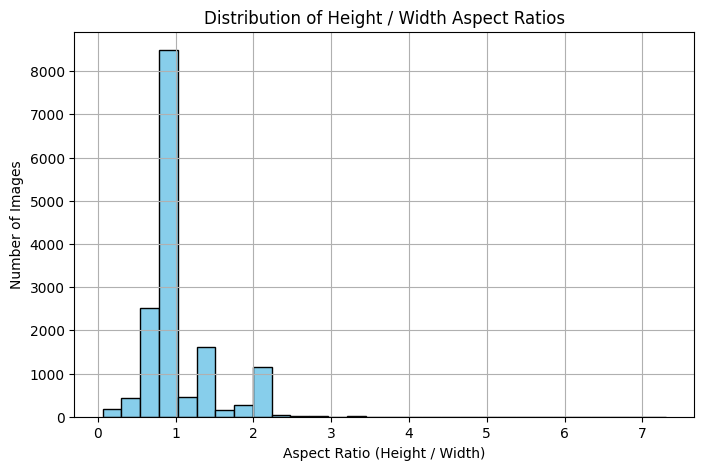

In [14]:
aspect_ratios = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path)
                width, height = img.size
                if width > 0:  # Avoid division by zero
                    aspect_ratios.append(height / width)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

# Plotting histogram of aspect ratios
plt.figure(figsize=(8, 5))
plt.hist(aspect_ratios, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Height / Width Aspect Ratios")
plt.xlabel("Aspect Ratio (Height / Width)")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()


In [15]:
from hashlib import md5

hashes = set()
duplicates = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with open(img_path, 'rb') as f:
                file_hash = md5(f.read()).hexdigest()
            if file_hash in hashes:
                duplicates.append(img_path)
            else:
                hashes.add(file_hash)
        except:
            print("Corrupt image:", img_path)


Corrupt image: /kaggle/input/20k-multi-class-crop-disease-images/Train/Healthy Wheat/Wheat___Healthy


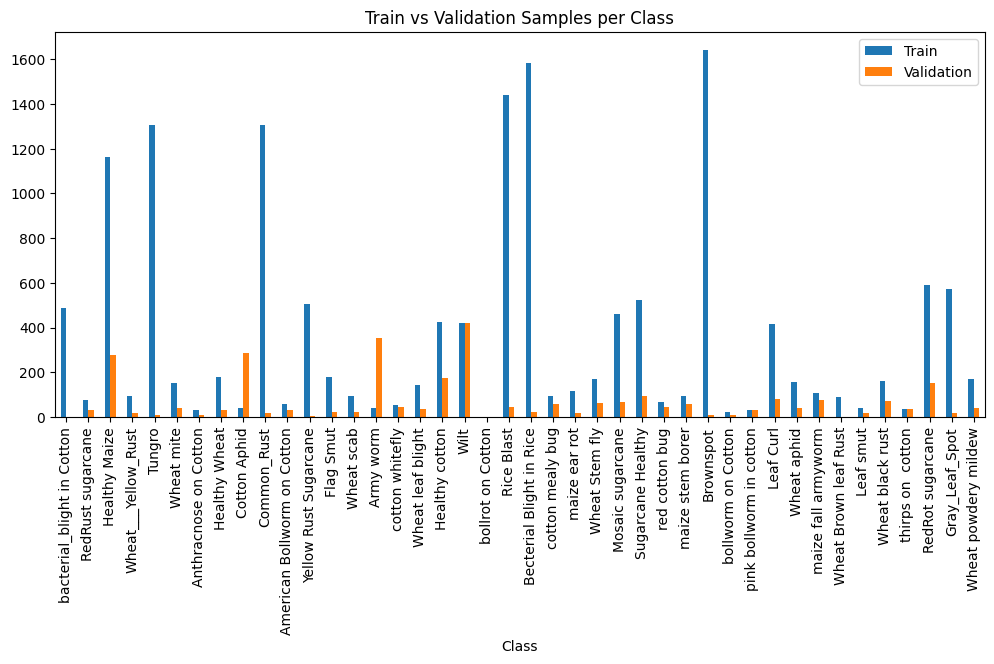

In [16]:
import pandas as pd

df = pd.DataFrame({
    'Class': train_dist.keys(),
    'Train': train_dist.values(),
    'Validation': [val_dist.get(cls, 0) for cls in train_dist.keys()]
})

df.plot(kind='bar', x='Class', figsize=(12, 5))
plt.title("Train vs Validation Samples per Class")
plt.xticks(rotation=90)
plt.show()


In [17]:
def count_images_per_class(folder):
    class_counts = {}
    for class_name in sorted(os.listdir(folder)):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = count
    return class_counts

train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)

print("Number of classes in Train:", len(train_counts))
print("Number of classes in Validation:", len(val_counts))


Number of classes in Train: 42
Number of classes in Validation: 42


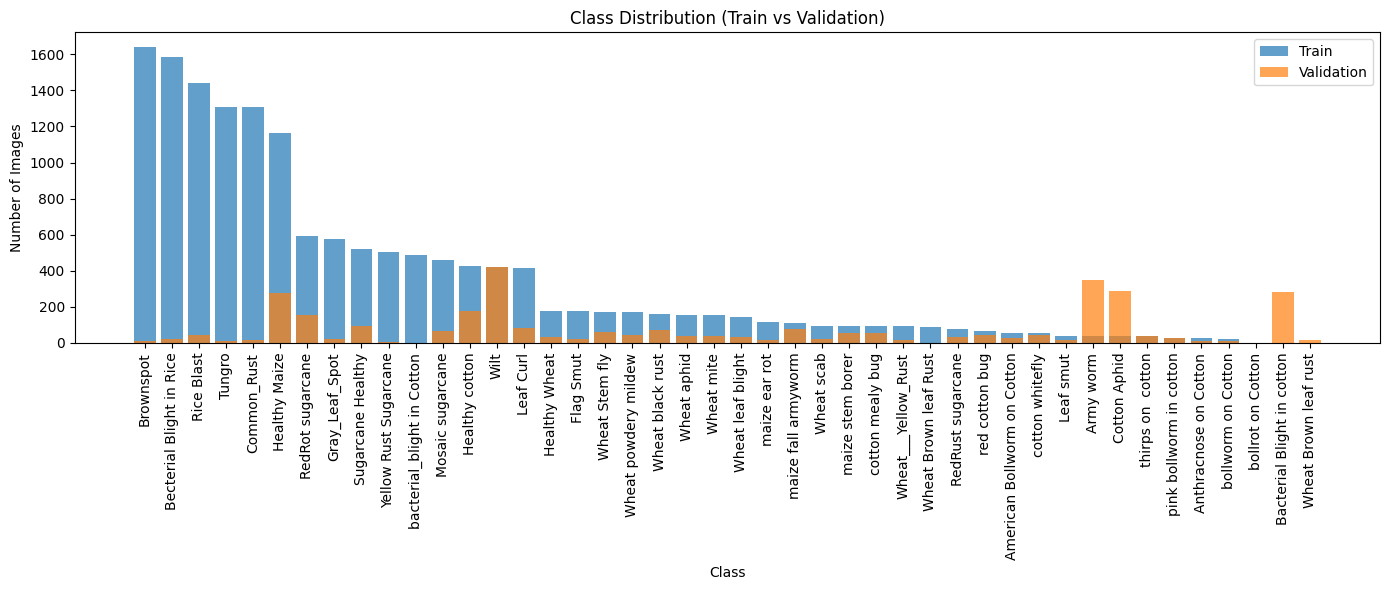

In [18]:
# Convert to DataFrame
train_df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Train Count'])
val_df = pd.DataFrame(list(val_counts.items()), columns=['Class', 'Val Count'])

# Merge
dist_df = pd.merge(train_df, val_df, on='Class', how='outer').fillna(0).sort_values(by='Train Count', ascending=False)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(dist_df['Class'], dist_df['Train Count'], label='Train', alpha=0.7)
plt.bar(dist_df['Class'], dist_df['Val Count'], label='Validation', alpha=0.7)
plt.xticks(rotation=90)
plt.title('Class Distribution (Train vs Validation)')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
top_classes = dist_df.head(5)
bottom_classes = dist_df.tail(5)

print("🏆 Top 5 classes with most images:")
print(top_classes[['Class', 'Train Count', 'Val Count']])

print("\n⚠️ Bottom 5 classes with fewest images:")
print(bottom_classes[['Class', 'Train Count', 'Val Count']])


🏆 Top 5 classes with most images:
                       Class  Train Count  Val Count
5                  Brownspot       1640.0        9.0
4   Becterial Blight in Rice       1584.0       22.0
18                Rice Blast       1440.0       44.0
20                    Tungro       1308.0        9.0
6                Common_Rust       1306.0       18.0

⚠️ Bottom 5 classes with fewest images:
                         Class  Train Count  Val Count
1        Anthracnose on Cotton         29.0       10.0
35          bollworm on Cotton         22.0       10.0
34           bollrot on Cotton          2.0        2.0
3   Bacterial Blight in cotton          0.0      284.0
22       Wheat Brown leaf rust          0.0       15.0


In [20]:
from tqdm import tqdm

def resize_images(input_dir, output_dir, target_size=(224, 224)):
    os.makedirs(output_dir, exist_ok=True)
    for class_name in tqdm(os.listdir(input_dir)):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(target_size)
                img.save(os.path.join(output_class_path, img_name))
            except:
                continue

# Resize Train and Validation sets
resize_images(train_dir, 'resized_data/Train')
resize_images(val_dir, 'resized_data/Validation')


 67%|██████▋   | 28/42 [01:52<00:50,  3.58s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 14%|█▍        | 6/42 [00:04<00:21,  1.66it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
100%|██████████| 42/42 [01:15<00:00,  1.81s/it]


In [21]:
import shutil
from sklearn.model_selection import train_test_split

def stratified_split(resized_data_path, output_path, train_ratio=0.8):
    all_classes = os.listdir(resized_data_path)
    
    for cls in tqdm(all_classes):
        class_path = os.path.join(resized_data_path, cls)
        images = os.listdir(class_path)
        
        if len(images) < 2:
            continue

        train_imgs, val_imgs = train_test_split(images, train_size=train_ratio, random_state=42)

        # Train folder
        train_cls_path = os.path.join(output_path, 'Train', cls)
        os.makedirs(train_cls_path, exist_ok=True)
        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_cls_path, img))

        # Val folder
        val_cls_path = os.path.join(output_path, 'Validation', cls)
        os.makedirs(val_cls_path, exist_ok=True)
        for img in val_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_cls_path, img))


stratified_split('resized_data/Train', 'final_data', train_ratio=0.8)


100%|██████████| 42/42 [00:01<00:00, 27.89it/s]


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [23]:
def create_cnn_model(input_shape=(224, 224, 3), num_classes=42):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # Block 4
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    # Dense Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [24]:
model = create_cnn_model(num_classes=42)  # change if your classes differ

model.compile(
    loss='categorical_crossentropy',  # perfect for multi-class classification
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'final_data/Train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'final_data/Validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 12255 images belonging to 42 classes.
Found 3081 images belonging to 42 classes.


In [26]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1750005582.263078      98 service.cc:148] XLA service 0x7b4164050e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750005582.263862      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750005582.263882      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750005582.811525      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/383 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.0234 - loss: 8.1197       

I0000 00:00:1750005591.636959      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/383 ━━━━━━━━━━━━━━━━━━━━ 153s 362ms/step - accuracy: 0.3191 - loss: 3.4709 - val_accuracy: 0.0659 - val_loss: 23.3067
Epoch 2/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 125s 327ms/step - accuracy: 0.4914 - loss: 2.0650 - val_accuracy: 0.4706 - val_loss: 5.0679
Epoch 3/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 123s 321ms/step - accuracy: 0.5456 - loss: 1.8146 - val_accuracy: 0.5852 - val_loss: 3.3898
Epoch 4/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 125s 326ms/step - accuracy: 0.5776 - loss: 1.6817 - val_accuracy: 0.5615 - val_loss: 3.9840
Epoch 5/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 124s 324ms/step - accuracy: 0.6002 - loss: 1.5843 - val_accuracy: 0.5060 - val_loss: 5.6049
Epoch 6/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 123s 321ms/step - accuracy: 0.6237 - loss: 1.4780 - val_accuracy: 0.5144 - val_loss: 6.3360
Epoch 7/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 126s 328ms/step - accuracy: 0.6383 - loss: 1.4157 - val_accuracy: 0.5849 - val_loss: 4.1814
Epoch 8/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 124s 325ms/step - accuracy: 0.6514 - loss: 1.3

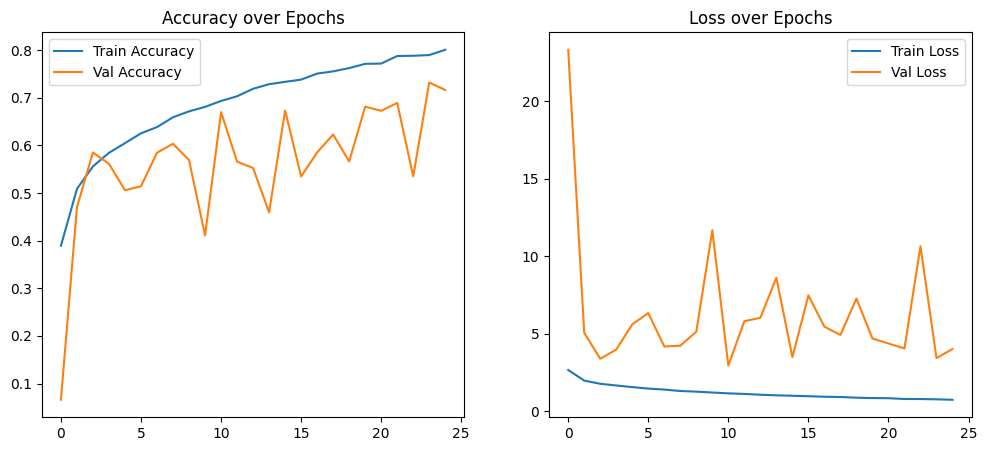

In [27]:

def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.show()

plot_history(history)

In [28]:
model.evaluate(val_generator)

97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7276 - loss: 3.8182


[4.016621112823486, 0.7166504263877869]

97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


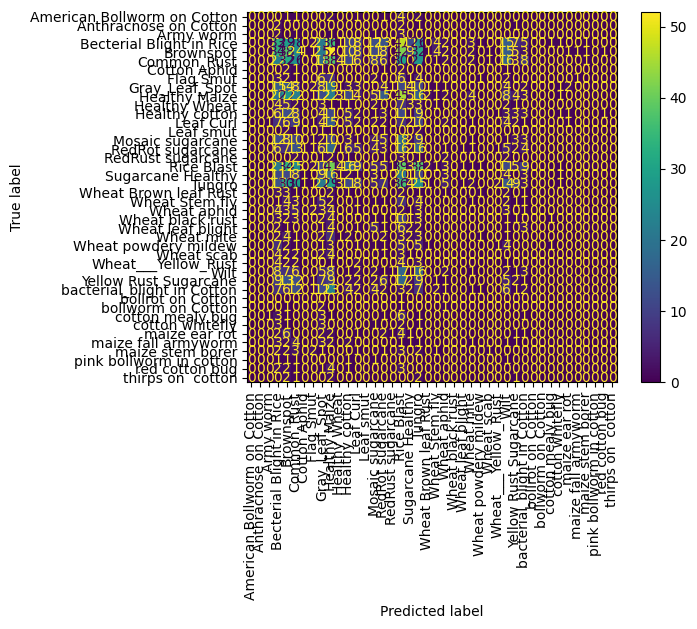

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true and predicted labels
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices)
disp.plot(xticks_rotation=90)


In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))


                             precision    recall  f1-score   support

American Bollworm on Cotton       0.00      0.00      0.00        12
      Anthracnose on Cotton       0.00      0.00      0.00         6
                  Army worm       0.00      0.00      0.00         8
   Becterial Blight in Rice       0.12      0.10      0.11       317
                  Brownspot       0.12      0.12      0.12       328
                Common_Rust       0.09      0.10      0.10       262
               Cotton Aphid       0.00      0.00      0.00         8
                  Flag Smut       0.00      0.00      0.00        36
             Gray_Leaf_Spot       0.04      0.07      0.05       115
              Healthy Maize       0.05      0.09      0.07       233
              Healthy Wheat       0.05      0.03      0.04        36
             Healthy cotton       0.05      0.06      0.05        86
                  Leaf Curl       0.03      0.02      0.03        84
                  Leaf smut      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


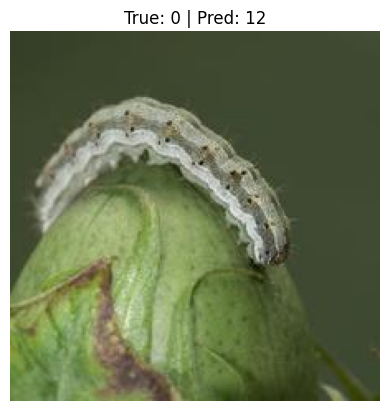

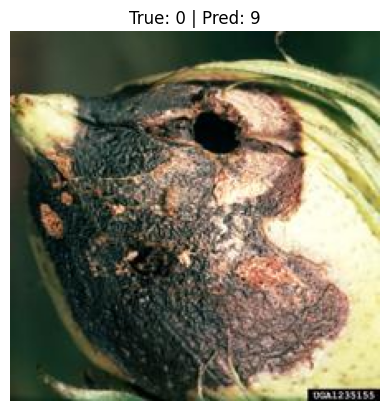

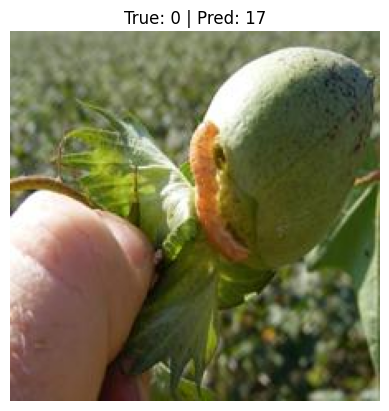

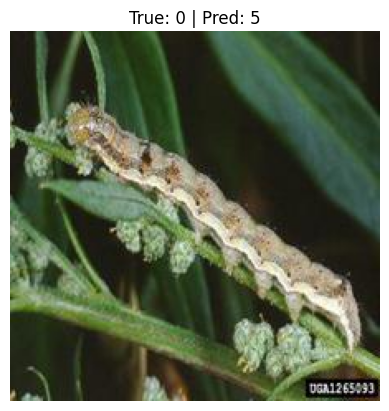

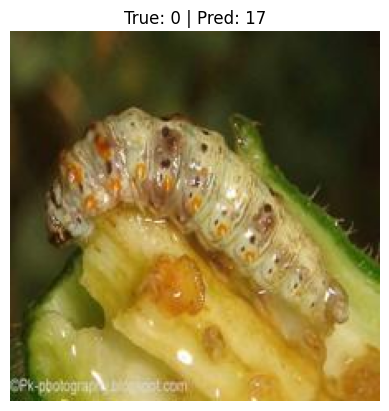

In [32]:
# Get filenames
filenames = val_generator.filenames
misclassified_idx = np.where(y_pred_classes != y_true)[0]

for i in misclassified_idx[:5]:  # Show 5 examples
    img_path = os.path.join('final_data/Validation', filenames[i])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"True: {y_true[i]} | Pred: {y_pred_classes[i]}")
    plt.axis('off')
    plt.show()


In [33]:
model.save('crop_disease_cnn_model.h5')